In [1]:
#| default_exp core

In [2]:
# Drawing with LLMs - System Kaggle - RAG + LLM Local 
#| export

import pandas as pd
import numpy as np
import json
import re
import xml.etree.ElementTree as ET
from typing import Dict, List, Tuple
from dataclasses import dataclass
from datetime import datetime
from enum import Enum
from typing import Dict, List, Tuple, Optional

# --- LLM local (HuggingFace) --- #
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline, BitsAndBytesConfig
import torch
from huggingface_hub import login

# --- Category RAG with Embeddings --- #
from sentence_transformers import SentenceTransformer

# --- Kaggle Secrets --- #
from kaggle_secrets import UserSecretsClient
import kagglehub

import kaggle_evaluation
import logging

2025-07-12 03:39:54.911407: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752291595.278383     344 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752291595.384239     344 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
user_secrets = UserSecretsClient()
hf_token = user_secrets.get_secret("HF_TOKEN") 

login(token=hf_token, add_to_git_credential=False)

In [4]:
class Category(Enum):
    LANDSCAPE = "landscape"
    ABSTRACT = "abstract"
    FASHION = "fashion"
    UNKNOWN = "unknown"

In [5]:
#| export
# --- PromptGenerator (usa RAG embeddings) ---
class PromptGenerator:

    template:str = """
        GENERATE SVG CODE ONLY. NO TEXT.
        Your task is to create a valid SVG image based on the following details.
        Do not include any text, explanations, or comments outside of the SVG code itself.
        Description:
        {description}
        Instructions & Constraints:
        1.  SVG ONLY: The entire output must be valid SVG code starting with `<svg` and ending with `</svg>`.
        2.  VARIETY OF SHAPES: You MUST use a variety of SVG elements to create the image. Do not only use `<path>`. Use elements like `<rect>`, `<circle>`, `<ellipse>`, `<polygon>`, and `<line>`.
        3.  Category Hints: {category_hints}
        4.  Technical Constraints: {constraints}
        5.  NO CSS: Do not use `<style>` tags or `style` attributes.
        6.  NO TEXT ELEMENTS: Do not use the `<text>` element.
    """.strip()
    def __init__(self, constrains_class):
        self.embedder = SentenceTransformer("all-MiniLM-L6-v2")
        self.category_embeddings = self.embedder.encode([c.value for c in Category if c != Category.UNKNOWN])
        self.max_bytes = constrains_class.max_svg_size
        allowed_elements_dict = self._get_constrains()

        # Allowed elements are all keys EXCEPT 'common'
        self.allowed_elements = set(key for key in allowed_elements_dict.keys() if key != 'common')
        self.allowed_elements.union(*allowed_elements_dict["common"])
        
        # Allowed attributes are the union of attributes under each element key
        self.allowed_attributes = set()
        for element, attributes in allowed_elements_dict.items():
            self.allowed_attributes.update(attributes)

    
    def _format_constraints(self) -> str:
        constraints = [
            f"Maximum {self.max_bytes} bytes",
            f"Only use elements: ({', '.join(sorted(list(self.allowed_elements)))})",
            f"Allowed Attributes: ({', '.join(sorted(list(self.allowed_attributes)))})",
            "No CSS styling or external references",
            "No rasterized image data"
        ]
        return "; ".join(constraints)


    def generate_prompt(self, description: str) -> Tuple[str, str]:
        constraints_text = self._format_constraints()
        category = self._categorize_with_embeddings(description)
        prompt_tmpl = PromptGenerator.template
        category_hints = self._get_category_hints(category)
        prompt = prompt_tmpl.format(description=description, constraints=constraints_text, category_hints=category_hints)
        return prompt, category.value

    def _categorize_with_embeddings(self, description) -> Category:
        desc_emb = self.embedder.encode([description])[0]
        similarities = np.dot(self.category_embeddings, desc_emb)
        best_idx = np.argmax(similarities)
        best_category = list(Category)[best_idx]
        return best_category

    def _get_constrains(self) -> dict[str, set[str]]:
        return {
            'common': {
                'id',
                'clip-path',
                'clip-rule',
                'color',
                'color-interpolation',
                'color-interpolation-filters',
                'color-rendering',
                'display',
                'fill',
                'fill-opacity',
                'fill-rule',
                'filter',
                'flood-color',
                'flood-opacity',
                'lighting-color',
                'marker-end',
                'marker-mid',
                'marker-start',
                'mask',
                'opacity',
                'paint-order',
                'stop-color',
                'stop-opacity',
                'stroke',
                'stroke-dasharray',
                'stroke-dashoffset',
                'stroke-linecap',
                'stroke-linejoin',
                'stroke-miterlimit',
                'stroke-opacity',
                'stroke-width',
                'transform',
            },
            'svg': {
                'width',
                'height',
                'viewBox',
                'preserveAspectRatio',
            },
            'g': {'viewBox'},
            'defs': set(),
            'symbol': {'viewBox', 'x', 'y', 'width', 'height'},
            'use': {'x', 'y', 'width', 'height', 'href'},
            'marker': {
                'viewBox',
                'preserveAspectRatio',
                'refX',
                'refY',
                'markerUnits',
                'markerWidth',
                'markerHeight',
                'orient',
            },
            'pattern': {
                'viewBox',
                'preserveAspectRatio',
                'x',
                'y',
                'width',
                'height',
                'patternUnits',
                'patternContentUnits',
                'patternTransform',
                'href',
            },
            'linearGradient': {
                'x1',
                'x2',
                'y1',
                'y2',
                'gradientUnits',
                'gradientTransform',
                'spreadMethod',
                'href',
            },
            'radialGradient': {
                'cx',
                'cy',
                'r',
                'fx',
                'fy',
                'fr',
                'gradientUnits',
                'gradientTransform',
                'spreadMethod',
                'href',
            },
            'stop': {'offset'},
            'filter': {
                'x',
                'y',
                'width',
                'height',
                'filterUnits',
                'primitiveUnits',
            },
            'feBlend': {'result', 'in', 'in2', 'mode'},
            'feColorMatrix': {'result', 'in', 'type', 'values'},
            'feComposite': {
                'result',
                'style',
                'in',
                'in2',
                'operator',
                'k1',
                'k2',
                'k3',
                'k4',
            },
            'feFlood': {'result'},
            'feGaussianBlur': {
                'result',
                'in',
                'stdDeviation',
                'edgeMode',
            },
            'feMerge': {
                'result',
                'x',
                'y',
                'width',
                'height',
                'result',
            },
            'feMergeNode': {'result', 'in'},
            'feOffset': {'result', 'in', 'dx', 'dy'},
            'feTurbulence': {
                'result',
                'baseFrequency',
                'numOctaves',
                'seed',
                'stitchTiles',
                'type',
            },
            'path': {'d'},
            'rect': {'x', 'y', 'width', 'height', 'rx', 'ry'},
            'circle': {'cx', 'cy', 'r'},
            'ellipse': {'cx', 'cy', 'rx', 'ry'},
            'line': {'x1', 'y1', 'x2', 'y2'},
            'polyline': {'points'},
            'polygon': {'points'},
        }
    
    
    def _get_category_hints(self, category: Optional[Category]) -> str:
        """Get category-specific optimization hints"""
        hints = {
            Category.LANDSCAPE: "natural scenes, outdoor environments, horizon lines",
            Category.ABSTRACT: "geometric shapes, artistic patterns, non-representational forms",
            Category.FASHION: "clothing items, accessories, style elements",
            Category.UNKNOWN: "general visual representation"
        }
        return hints.get(category, hints[Category.UNKNOWN])


In [6]:
#| export
# --- Local ModelLLM (HuggingFace pipeline) ---
class ModelLLM:
    def __init__(self, model_pipe):
        self.model_pipe = model_pipe
    def predict(self, prompt: str) -> list[str]:
        try:
            results = self.model_pipe(
                prompt,
                return_full_text=False,
                max_new_tokens=8192,
            )
            generated = results[0]["generated_text"]
            svg_match = re.search(r'(<svg.*?</svg>)', generated, re.DOTALL)
            if svg_match:
                logging.debug('SVG Generated')
                return svg_match.group(1).strip()
            else:
                logging.warning("Warning: Could not find SVG in response.")
                return ""
        except Exception as e:
            logging.error(f"Error during LLM prediction: {e}")
            return ""


In [7]:
class InputHandler:
    def load_data(number_descriptions = -1):
        df = list(pd.read_csv('/kaggle/input/drawing-with-llms/train.csv')["description"])
        if number_descriptions == -1:
            number_descriptions = len(df)
        return df[0:number_descriptions]

In [8]:
#| export
class Model:
    def __init__(self):
        DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        
        llm_model_name = "mistralai/Mistral-7B-Instruct-v0.3"  # or "microsoft/phi-2", "mistralai/Mistral-7B-Instruct-v0.3", "google/gemma-7b-it", "Qwen2.5-VL-7B-Instruct", "deepseek-ai/DeepSeek-R1-Distill-Qwen-7B" etc.
        
        quantization_config = BitsAndBytesConfig(
                     load_in_4bit=True,
                     bnb_4bit_quant_type="nf4",
                     bnb_4bit_use_double_quant=True,
                     bnb_4bit_compute_dtype=torch.float16,
                 )
        
        tokenizer = AutoTokenizer.from_pretrained(llm_model_name)
        model = AutoModelForCausalLM.from_pretrained(
            llm_model_name,
            device_map="auto",
            quantization_config = quantization_config,
        )
        llm_pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)
        if llm_pipe.tokenizer.pad_token_id is None:
            llm_pipe.tokenizer.pad_token = llm_pipe.tokenizer.eos_token
            llm_pipe.tokenizer.pad_token_id = llm_pipe.tokenizer.eos_token_id
            llm_pipe.tokenizer.padding_side = "left"  
        
        self.svg_constrains_class = (kagglehub.package_import("metric/svg-constraints")).SVGConstraints
        self.prompt_generator = PromptGenerator(self.svg_constrains_class)
        self.llm_generator = ModelLLM(llm_pipe)
        
    def predict(self,description):
        prompt, category = self.prompt_generator.generate_prompt(description)
        logging.debug("Prompt generated")
        return self.llm_generator.predict(prompt)

id,description
str,str
"""02d892""","""a purple forest at dusk"""
"""0dcd2e""","""gray wool coat with a faux fur…"
"""1e9ac1""","""a lighthouse overlooking the o…"
"""2b25db""","""burgundy corduroy pants with p…"
"""4e6a54""","""orange corduroy overalls"""


DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /mistralai/Mistral-7B-Instruct-v0.3/resolve/main/tokenizer_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "GET /api/models/mistralai/Mistral-7B-Instruct-v0.3/tree/main/additional_chat_templates?recursive=False&expand=False HTTP/1.1" 404 64
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /mistralai/Mistral-7B-Instruct-v0.3/resolve/main/config.json HTTP/1.1" 200 0
DEBUG:bitsandbytes.cextension:Loading bitsandbytes native library from: /usr/local/lib/python3.11/dist-packages/bitsandbytes/libbitsandbytes_cuda124.so


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /mistralai/Mistral-7B-Instruct-v0.3/resolve/main/generation_config.json HTTP/1.1" 200 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /mistralai/Mistral-7B-Instruct-v0.3/resolve/main/custom_generate/generate.py HTTP/1.1" 404 0
Device set to use cuda:0
DEBUG:urllib3.connectionpool:Starting new HTTPS connection (1): dp.kaggle.net:443
DEBUG:urllib3.connectionpool:https://dp.kaggle.net:443 "POST /kaggle-jwt-handler/AttachDatasourceUsingJwtRequest HTTP/1.1" 200 None
INFO:sentence_transformers.SentenceTransformer:Use pytorch device_name: cuda:0
INFO:sentence_transformers.SentenceTransformer:Load pretrained SentenceTransformer: all-MiniLM-L6-v2
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /sentence-transformers/all-MiniLM-L6-v2/resolve/main/modules.json HTTP/1.1" 307 0
DEBUG:urllib3.connectionpool:https://huggingface.co:443 "HEAD /api/resolve-cache/models/sentence-transformers/all-MiniLM-L6-v2/c9745

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:root:Prompt generated
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
DEBUG:root:SVG Generated


Prediction time for description 'a purple forest at d...': 97.9569 seconds


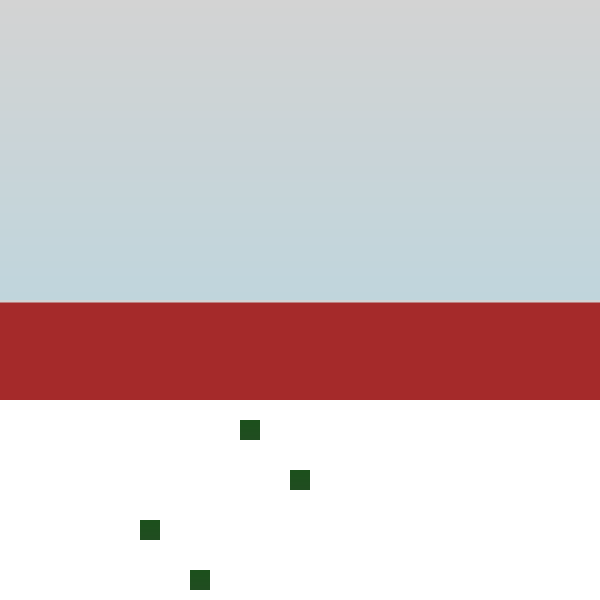

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:root:Prompt generated
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
DEBUG:root:SVG Generated


Prediction time for description 'gray wool coat with ...': 60.7518 seconds


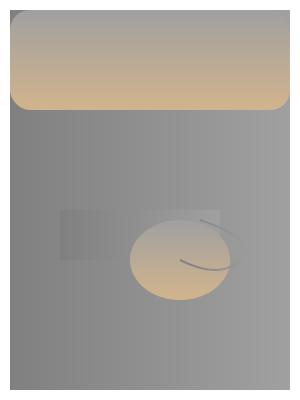

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:root:Prompt generated
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
DEBUG:root:SVG Generated


Prediction time for description 'a lighthouse overloo...': 96.8165 seconds
unbound prefix: line 30, column 4


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:root:Prompt generated
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
DEBUG:root:SVG Generated


Prediction time for description 'burgundy corduroy pa...': 104.3356 seconds


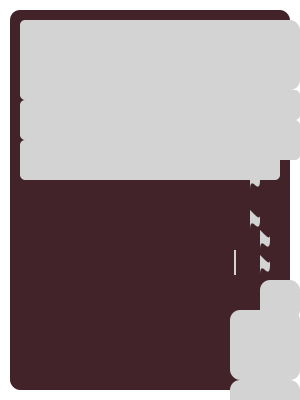

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:root:Prompt generated
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
DEBUG:root:SVG Generated


Prediction time for description 'orange corduroy over...': 71.8073 seconds


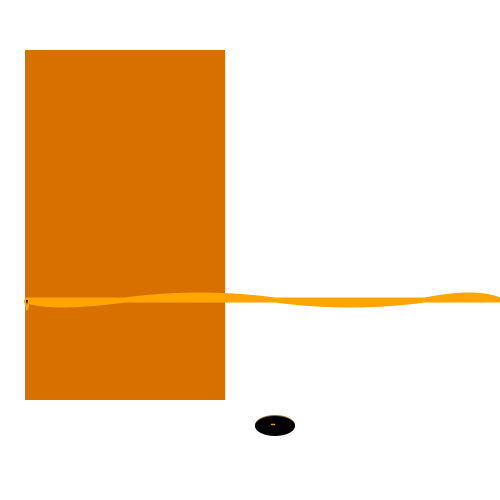

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:root:Prompt generated
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
DEBUG:root:SVG Generated


Prediction time for description 'a purple silk scarf ...': 67.4876 seconds
unbound prefix: line 26, column 2


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:root:Prompt generated
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
DEBUG:root:SVG Generated


Prediction time for description 'a green lagoon under...': 65.1927 seconds


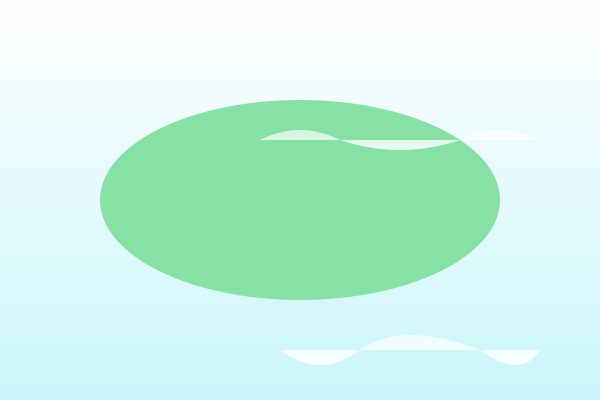

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:root:Prompt generated
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
DEBUG:root:SVG Generated


Prediction time for description 'crimson rectangles f...': 71.9027 seconds


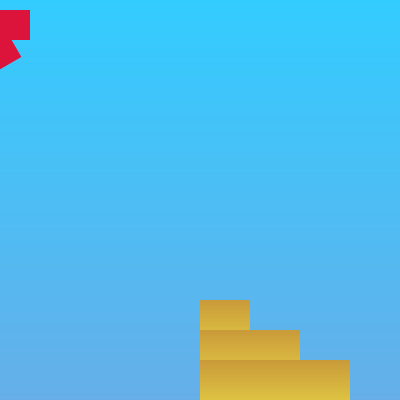

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:root:Prompt generated
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
DEBUG:root:SVG Generated


Prediction time for description 'purple pyramids spir...': 78.8926 seconds
unbound prefix: line 19, column 4


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:root:Prompt generated
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
DEBUG:root:SVG Generated


Prediction time for description 'magenta trapezoids l...': 61.9075 seconds


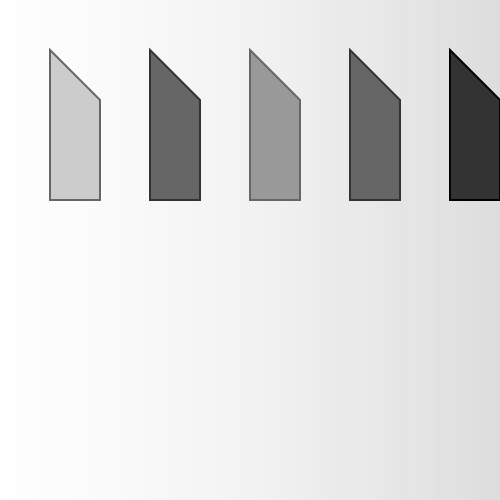

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:root:Prompt generated
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
DEBUG:root:SVG Generated


Prediction time for description 'a snowy plain...': 36.6465 seconds


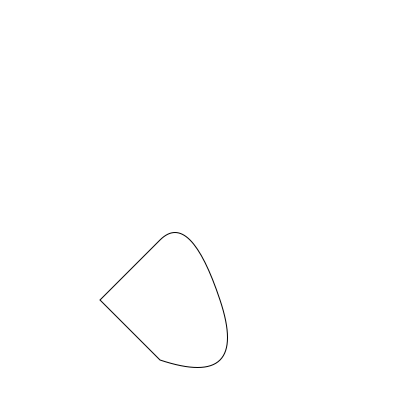

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:root:Prompt generated
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
DEBUG:root:SVG Generated


Prediction time for description 'black and white chec...': 43.0608 seconds
not well-formed (invalid token): line 12, column 14


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:root:Prompt generated
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
DEBUG:root:SVG Generated


Prediction time for description 'a starlit night over...': 76.8985 seconds
unbound prefix: line 18, column 4


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:root:Prompt generated
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
DEBUG:root:SVG Generated


Prediction time for description 'khaki triangles and ...': 63.0960 seconds


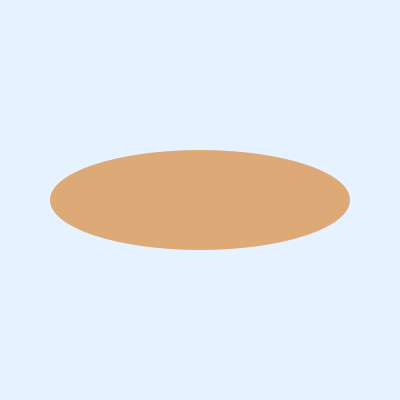

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

DEBUG:root:Prompt generated
Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.
DEBUG:root:SVG Generated


Prediction time for description 'a maroon dodecahedro...': 160.3635 seconds


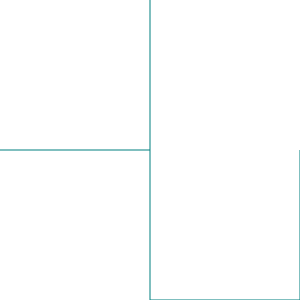

In [9]:
def generate():
    import polars as pl
    from IPython.display import SVG
    import time  # Import the time module
    
    logging.basicConfig(level=logging.DEBUG, force=True)
    
    train = pl.read_csv('/kaggle/input/drawing-with-llms/train.csv')
    display(train.head())
    
    model = Model()
    svgs = []
    for desc in train.get_column('description'):
        start_time = time.time()  # Record start time
        svg = model.predict(desc)
        end_time = time.time()    # Record end time
        elapsed_time = end_time - start_time # Calculate elapsed time
        print(f"Prediction time for description '{desc[:20]}...': {elapsed_time:.4f} seconds") # Print time
    
        try:
            display(SVG(svg))
        except Exception as e:
            print(e)
            continue

# Uncomment and run the line below to see some generated images
generate()